In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
!pip install catboost

In [148]:
# Mounting Google Drive in Colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [149]:
data = pd.read_csv('/content/gdrive/MyDrive/Omdena/IPAGE: Soil Nutrient Prediction for Enhanced Fertilizer Recommendations/merged_v2.csv')

In [150]:
data.shape

(2584, 17)

In [151]:
data.sample(10)

,longitude,latitude,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
2071,9.14898,8.34227,isda,isda,isda,isda,5.99826,1.073370,0.113824,0.045847,10.38170,9.04563,0.063914,0.865447,64.0,20.0,16.0
313,89.21670,25.85000,Gangachara,Gangachara,high ground,unknown,5.00000,1.200000,0.002000,0.210000,11.00000,15.00000,0.200000,1.000000,33.0,33.0,33.0
2413,6.12690,9.51312,isda,isda,isda,isda,6.14247,0.479560,0.030403,0.120492,2.71078,6.38832,0.004325,0.894749,70.0,18.0,14.0
231,89.40000,25.58000,Pirgacha,Gangachara,high ground,loam,5.00000,2.000000,0.130000,0.150000,15.80000,23.20000,0.430000,1.700000,40.0,40.0,20.0
952,10.05820,9.36562,isda,isda,isda,isda,6.56455,0.686420,0.051656,0.421326,4.38925,8.40046,0.191755,1.744640,58.0,15.0,21.0
2149,8.57113,9.38645,isda,isda,isda,isda,5.34820,1.105780,0.092141,0.260072,1.89067,8.37145,0.071038,1.544220,59.0,20.0,23.0
2246,6.98239,11.07422,isda,isda,isda,isda,6.07183,0.752472,0.063771,0.247321,1.53531,9.48835,0.083005,0.876531,59.0,23.0,17.0
1839,7.12188,11.61626,isda,isda,isda,isda,5.98008,0.931367,0.048589,0.209424,4.16816,6.26978,0.047414,1.433510,50.0,24.0,22.0
1227,6.04807,9.47965,isda,isda,isda,isda,5.99445,0.479832,0.026278,0.094284,3.15112,3.87331,0.015384,0.774479,69.0,19.0,12.0
2330,4.51957,9.86628,isda,isda,isda,isda,6.46670,0.573006,0.049439,0.438523,10.06990,9.61310,0.094649,1.458260,68.0,18.0,14.0


In [152]:
data.describe()

,longitude,latitude,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,22.979895,12.711743,5.869107,1.002453,0.070375,0.238226,8.586086,8.843246,0.113593,1.187543,56.202786,22.819659,20.175310
std,31.597277,6.212016,0.518722,0.626685,0.039282,0.140441,9.266400,5.267589,0.132118,0.470586,10.998711,7.472131,5.535707
min,4.430300,8.039070,4.100000,0.100000,0.000800,0.000000,0.060000,0.650000,0.001611,0.080000,20.000000,10.000000,10.000000
25%,6.972760,9.251048,5.536365,0.553925,0.040000,0.138462,3.664697,5.668802,0.024444,0.879671,51.000000,18.000000,16.000000
50%,8.617840,9.971485,5.913315,0.807029,0.062176,0.209134,5.714590,7.243420,0.060213,1.143550,58.000000,20.000000,20.000000
75%,10.430405,11.159215,6.226348,1.290080,0.092213,0.313721,9.579792,10.298875,0.154269,1.443010,64.000000,24.000000,22.000000
max,89.416700,25.850000,7.945400,4.480000,0.257264,0.990000,74.500000,39.700000,0.990000,4.000000,80.000000,40.000000,60.000000


# Prepare Data for Modelling

**Remove the other labels**

In [153]:
data = data.drop(columns=['SOC', 'Boron'])

**Create additional data without outliers**

In [154]:
data_after =data.copy()
# Handling Outliers
def handle_outlier(df,col):
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3 - Q1
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

data_num = data_after.select_dtypes(include = ["float64", "int64"])

for column in data_num.columns:
    handle_outlier(data_after, column)


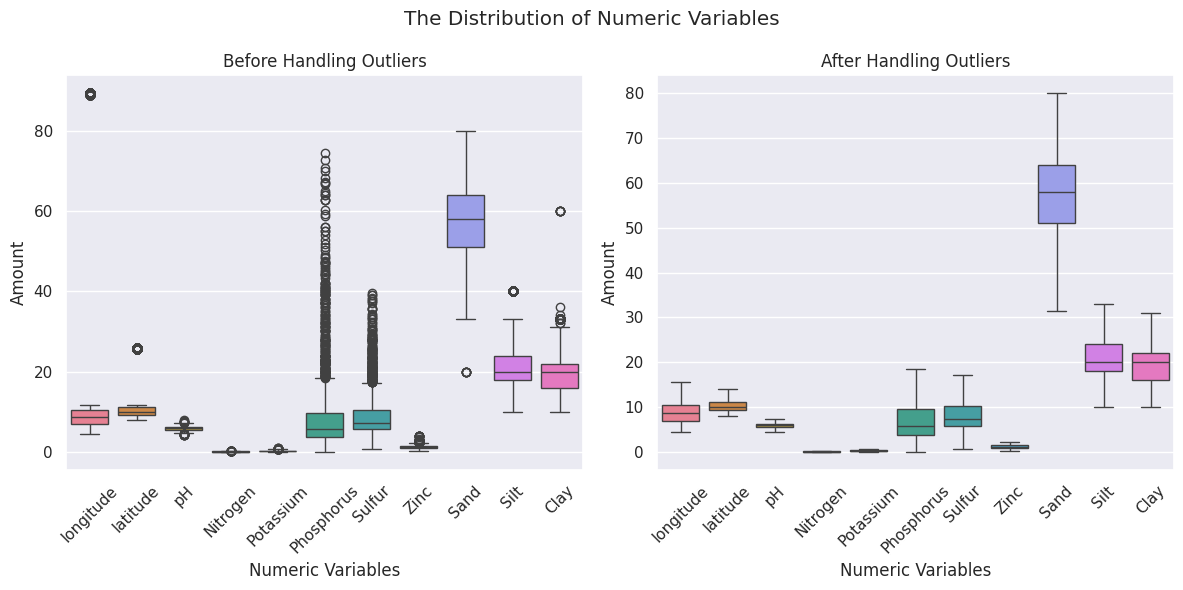

In [155]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data,ax=axes[0])
sns.boxplot(data_after,ax=axes[1])
axes[0].set_title("Before Handling Outliers")
axes[1].set_title("After Handling Outliers")
fig.suptitle("The Distribution of Numeric Variables")
axes[0].set_xlabel("Numeric Variables")
axes[1].set_xlabel("Numeric Variables")
axes[0].set_ylabel("Amount")
axes[1].set_ylabel("Amount")
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[1].set_xticks(axes[0].get_xticks())
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'The Correlation Heatmap between Numeric Variables')

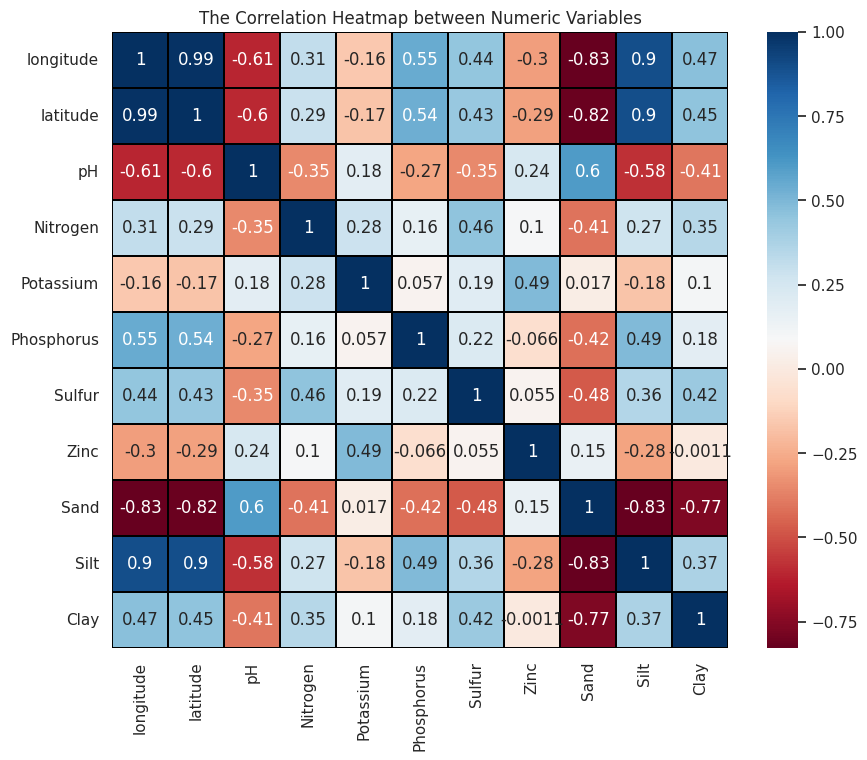

In [156]:
data_num = data.select_dtypes(include = ["float64", "int64"])
plt.figure(figsize=(10, 8))
heat=sns.heatmap(data_num.corr(), annot=True, linewidth=0.01, square=True, cmap="RdBu", linecolor="black")
heat.set_title("The Correlation Heatmap between Numeric Variables")

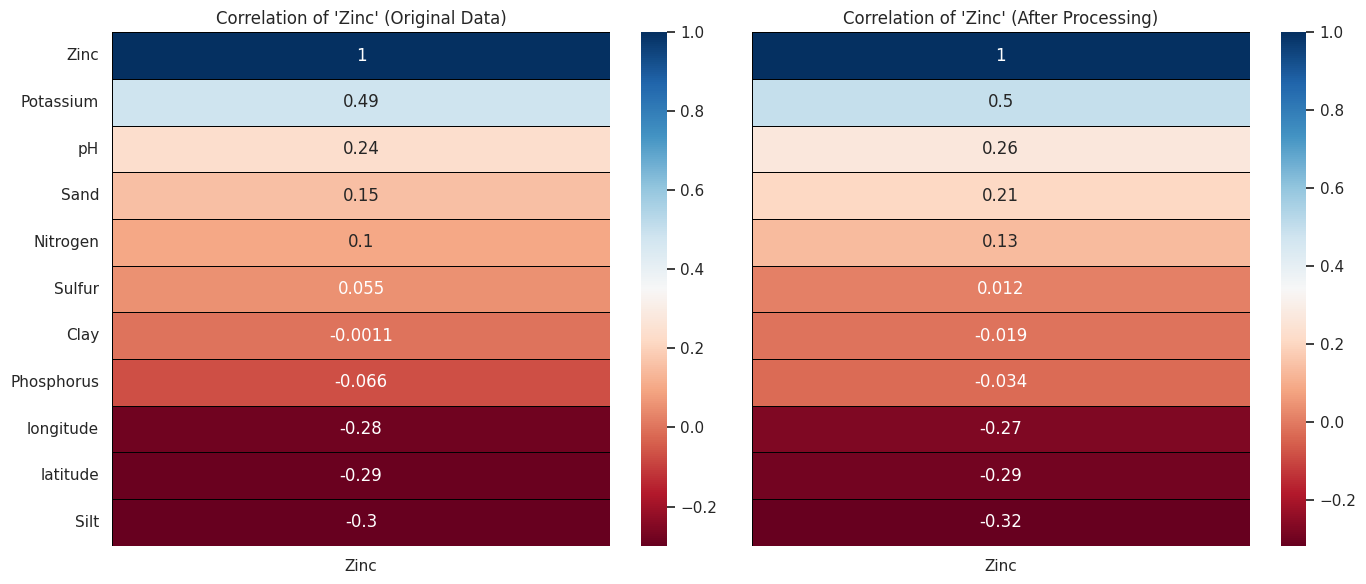

In [157]:
# Selecting numerical variables from both datasets
data_num = data.select_dtypes(include=["float64", "int64"])
data_after_num = data_after.select_dtypes(include=["float64", "int64"])

# Computing correlation matrices
corr_matrix = data_num.corr()
corr_matrix_after = data_after_num.corr()

# Filtering correlations to include only 'Zinc' row
zinc_corr = corr_matrix[['Zinc']].sort_values(by='Zinc', ascending=False)
zinc_corr_after = corr_matrix_after[['Zinc']].sort_values(by='Zinc', ascending=False)

# Plotting the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Heatmap for the original dataset
sns.heatmap(zinc_corr, annot=True, linewidth=0.5, cmap="RdBu", linecolor="black", cbar=True, ax=axes[0])
axes[0].set_title("Correlation of 'Zinc' (Original Data)")

# Heatmap for the data_after dataset
sns.heatmap(zinc_corr_after, annot=True, linewidth=0.5, cmap="RdBu", linecolor="black", cbar=True, ax=axes[1])
axes[1].set_title("Correlation of 'Zinc' (After Processing)")

# Adjust layout and show
plt.tight_layout()
plt.show()


In [158]:
data.select_dtypes(include = ["object"])

,Area,Soil group,Land class,Soil type
0,Mithpukur,belab,high ground,Clay loam
1,Mithpukur,belab,high ground,Clay loam
2,Mithpukur,belab,high ground,Clay loam
3,Mithpukur,belab,high ground,Clay loam
4,Mithpukur,belab,high ground,Clay loam
...,...,...,...,...
2579,isda,isda,isda,isda
2580,isda,isda,isda,isda
2581,isda,isda,isda,isda
2582,isda,isda,isda,isda


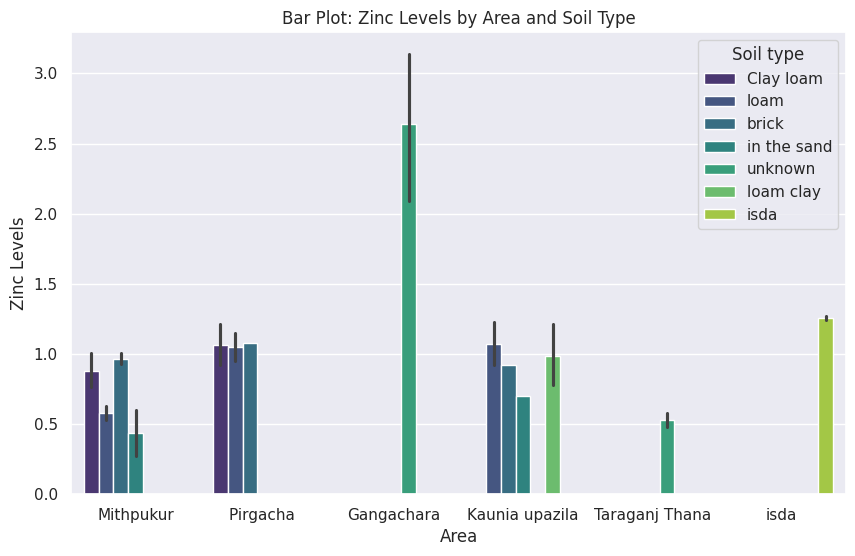

In [159]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Area', y='Zinc', data=data, hue='Soil type', palette='viridis')
plt.title('Bar Plot: Zinc Levels by Area and Soil Type')
plt.xlabel('Area')
plt.ylabel('Zinc Levels')
plt.show()

# Modelling

To enable modelling, I have made the following changes:

*   Encoding categorical features
*   Scaling the numeric features
*   Split the data into a training set and a test set




**Encoding categorical variables**

In [160]:
# Encode categorical columns using one-hot encoding
df_encoded = pd.get_dummies(data, columns=['Area', 'Soil group', 'Land class', 'Soil type'])

In [161]:
# Define X variables and our target(Zinc)
X = df_encoded.drop(["Zinc"],axis=1).values
y = df_encoded["Zinc"].values
print("X : ",X.shape," y : ",y.shape)

X :  (2584, 52)  y :  (2584,)


In [162]:
numeric_features = X[:, :10]

# Standardization
st_scaler = StandardScaler()
st_scaler.fit(numeric_features)
numeric_features_scaler = st_scaler.transform(numeric_features)

X_scaler = np.concatenate((numeric_features_scaler, X[:, 10:]), axis=1)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler,
              y, test_size= 0.20, random_state=42)

In [164]:
# Function to evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Output the results
    print(f"{model_name}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")
    print("\n")


In [177]:
# The Best Models that have good performance
rf_model = RandomForestRegressor(random_state=42,max_depth=None , n_estimators= 971)
xgboost_model = XGBRegressor(random_state=42, n_estimators=61, max_depth=None, learning_rate=0.1)
catboost_model = CatBoostRegressor(random_state=42, iterations=289, depth=6, learning_rate=0.1, verbose=0)

# Call the function for each model
evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest")
evaluate_model(xgboost_model, X_train, y_train, X_test, y_test, "XGBoost")
evaluate_model(catboost_model, X_train, y_train, X_test, y_test, "CatBoost")

Random Forest
Mean Squared Error (MSE): 0.10937180595935998
Mean Absolute Error (MAE): 0.24187185172716705
R-squared (R²): 0.5878536842097926


XGBoost
Mean Squared Error (MSE): 0.1147769892734482
Mean Absolute Error (MAE): 0.24701958719285266
R-squared (R²): 0.5674853052703431


CatBoost
Mean Squared Error (MSE): 0.11191311189617666
Mean Absolute Error (MAE): 0.24482787317367252
R-squared (R²): 0.5782772685150205




# Try Auto ML using H2O

In [178]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=8f3ac885c0a1d01a8270980b111cc9d12cd8f41dc8cf97c5d176f359c022f0ca
  Stored in directory: /root/.cache/pip/wheels/0c/95/eb/b449c73f478dbc4557b80170cf7f2aa6db15862877e9a63536
Successfully built h2o


In [184]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

# Initialize the H2O cluster
h2o.init()

# Convert pandas DataFrame to H2O frame
h2o_df = h2o.H2OFrame(data)

# Set the target and features
target = 'Zinc'
features = [col for col in h2o_df.columns if col != target]

# Split the data into train and test
train, test = h2o_df.split_frame(ratios=[0.8], seed=1234)

# Run AutoML for regression task
aml = H2OAutoML(max_models=20, seed=1234)
aml.train(x=features, y=target, training_frame=train)

# View the leaderboard of models
leaderboard = aml.leaderboard
print(leaderboard)

# Get the best model
best_model = aml.leader

# Make predictions on the test set
predictions = best_model.predict(test)

# Evaluate the performance of the model
performance = best_model.model_performance(test)
print(performance)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 min 42 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 21 days
H2O_cluster_name:,H2O_from_python_unknownUser_tellsw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse       mse       mae     rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_1_20241223_134500  0.319412  0.102024  0.233394  0.140428                  0.102024
StackedEnsemble_AllModels_1_AutoML_1_20241223_134500     0.321432  0.103319  0.233744  0.140757                  0.103319
DRF_1_AutoML_1_20241223_134500                           0.325159  0.105728  0.237469  0.142176                  0.105728
XRT_1_AutoML_1_20241223_134500                           0.325462  0.105926  0.238783  0.142952                  0.105926
GBM_5_AutoML_1_20241223_134500                           0.32597   0.106257  0.236081  0.142533                  0.106257
GBM_2_AutoML_1_20241223_134500                           0.327717  0.107398  0

# In Other Cases


*   Without outliers
*   Some columns have outliers, while others do not
*   With/without Scaler

*   Maybe try removing some columns that have a lower correlation with zinc ()

*   Using feature engineering techniques
*   Try diffrents models: AutoMl(TPOT, H2O) , traditional models

*   ...







